# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. Sample new $\tilde{Y}$ by Metropolis Hastings, using randomly perturbed versions of $\tilde{Y}$ as proposals, and using energy to compute the acceptance ratio.

---

 
Note: Exponential samples (i.e. energy distances) are larger with:
  - small privacy budget, $\alpha$
  - large sensitivity, $\Delta f$
  - large dimensionality, $d$
  - small energy exponent, $p$
  - small support point set, $N$.

___

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    get_energy_sensitivity,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_given_bandwidth)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
1.13.1


____

# 1. Global Config

Note: Exponential samples (i.e. energy distances) are smaller with:
  - large privacy budget, $\alpha$
  - small sensitivity, $\Delta f$
  - small dimensionality, $d$
  - large energy exponent, $p$
  - large support point set, $N$

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
MAX_ITER = 501                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

NUM_DATA = 200                   # Number of data points. [200]\
DIM = 2                          # Dimension of data. [2]
C = 10                           # Number of clusters in data. [10]
SIGMA_DATA = 0.03                # Bandwidth of data. [0.03]

NUM_SUPP = 10                    # Number of support points. [10]
ALPHA = 50                       # Differential privacy level. [50]
ENERGY_POWER = 1.                # Power for energy distance kernel. [2]

___

# 2. Load and Plot Data

In [3]:
# Load data.
np.random.seed(123)
x = load_balog_data(NUM_DATA, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)
#x = np.load('../../RKHS-private-database/data/mixture_of_Gaussians_N1000_D2_C10_SIG0.03.npz')['X_private']
print(x.shape)

Loaded M=200, DIM=2, SIG=0.03, C=10
(200, 2)


___

# 3. Run Support Point Optimization


STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0050


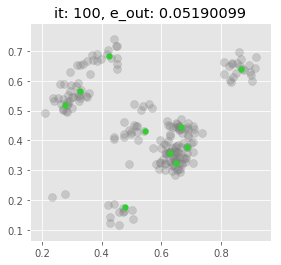

  [*] Overall it/s: 0.0055


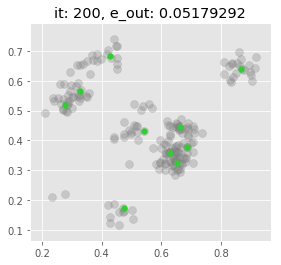

  [*] Overall it/s: 0.0061


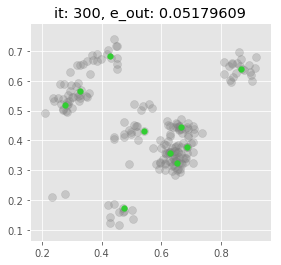

  [*] Overall it/s: 0.0061


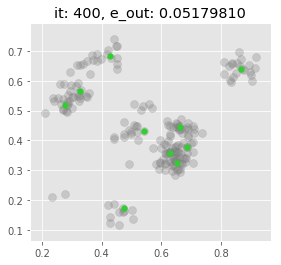

  [*] Overall it/s: 0.0064


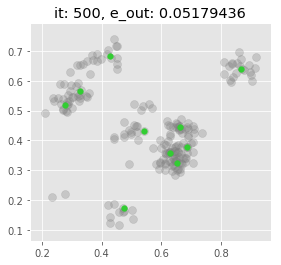

  [*] Time elapsed: 3.30


In [4]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, NUM_SUPP, MAX_ITER, LR, is_tf=IS_TF,
                                  power=2, Y_INIT_OPTION='random')  # NOTE: Power=2 to derive optimal SP.

#### Paper: Figure of support point optimization for variety of cluster sizes and counts.

Loaded M=200, DIM=2, SIG=0.02, C=5

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.14
Loaded M=200, DIM=2, SIG=0.02, C=10

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.10
Loaded M=200, DIM=2, SIG=0.02, C=30

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.09
Loaded M=200, DIM=2, SIG=0.04, C=5

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.08
Loaded M=200, DIM=2, SIG=0.04, C=10

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.05
Loaded M=200, DIM=2, SIG=0.04, C=30

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.05


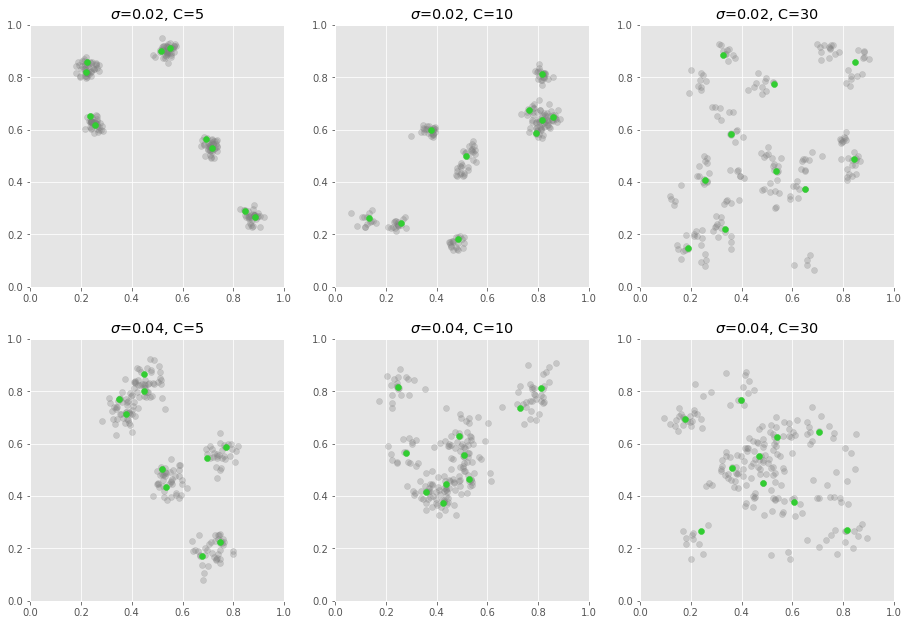

In [5]:
example_sigmas = [0.02, 0.04]
example_clusters = [5, 10, 30]
n_sig = len(example_sigmas)
n_clu = len(example_clusters)

fig, axs = plt.subplots(n_sig, n_clu, figsize=(5 * n_clu, 5 * n_sig))
for i, sigma in enumerate(example_sigmas):
    for j, cluster_count in enumerate(example_clusters):
        temp_data = load_balog_data(NUM_DATA, DIM, cluster_count, sigma, make_new=True,
                                    do_weighted=False)
        temp_y_opt, temp_e_opt = get_support_points(temp_data, NUM_SUPP, MAX_ITER,
                                                    LR, is_tf=IS_TF, power=2,
                                                    plot=False)

        axs[i, j].set_title('$\sigma$={}, C={}'.format(sigma, cluster_count))
        axs[i, j].scatter(temp_data[:, 0], temp_data[:, 1], c='gray', alpha=0.3)
        axs[i, j].scatter(temp_y_opt[:, 0], temp_y_opt[:, 1], c='limegreen', alpha=1)
        axs[i, j].set_xlim((0, 1))
        axs[i, j].set_ylim((0, 1))


plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.1, right=0.9)
plt.savefig('../output/sp_optimization_various_clusterings.png')

___

## 4. Sample support points.

## 4.0 Sample support points with SP + Exponential Mechanism.

Exp(2 * U / alpha) = Exp(2 * 0.7600 / 10000.00) = Exp(0.00015200)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 10000.000) = Exp(0.00015200)

Running chain. Length=205000, Burn=5000, Thin=2000
Difference factor: 6578.95

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00037247


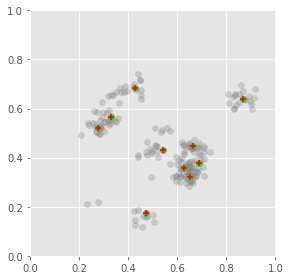

acceptance_rate=0.30393639, step_size=0.09223590
Energy diff: 0.00303426


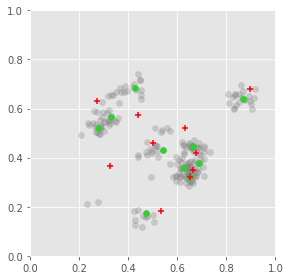

acceptance_rate=0.30033414, step_size=0.20033026
Energy diff: 0.00497316


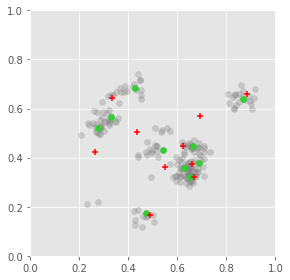

acceptance_rate=0.29841791, step_size=0.04201230
Energy diff: 0.00135224


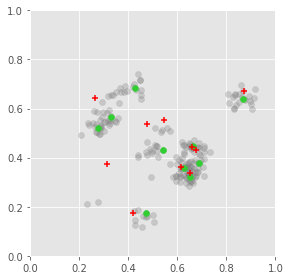

acceptance_rate=0.30119145, step_size=0.15300829
Energy diff: 0.00304796


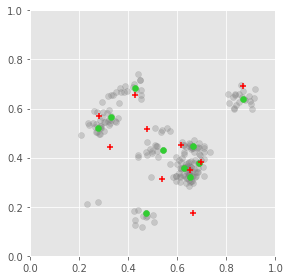

acceptance_rate=0.29972391, step_size=0.00288706
Energy diff: -0.00001100


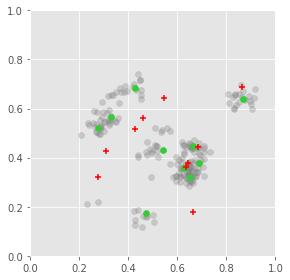

acceptance_rate=0.29973740, step_size=0.00360883
Energy diff: 0.00002346


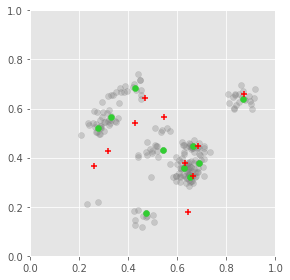

acceptance_rate=0.29935680, step_size=0.04201230
Energy diff: 0.00152862


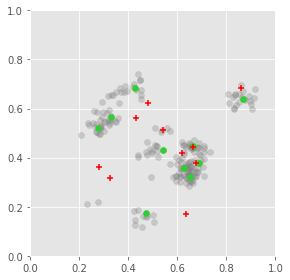

acceptance_rate=0.30045549, step_size=0.20033026
Energy diff: 0.00447031


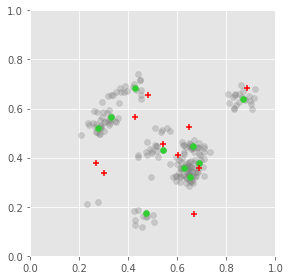

acceptance_rate=0.29976531, step_size=0.00360883
Energy diff: 0.00010548


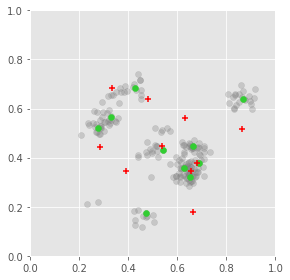

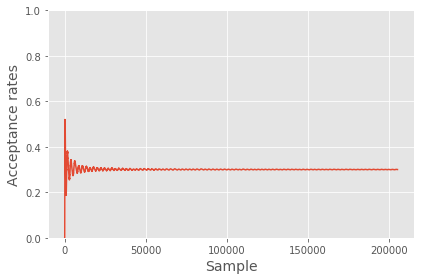

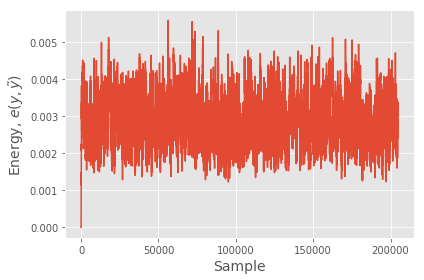

Acceptance rate: 0.300
percent steps that improved energy score: 0.150


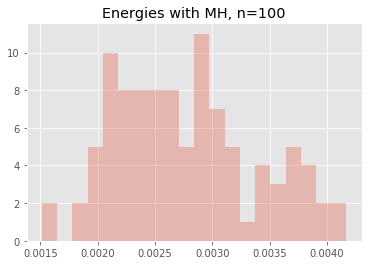

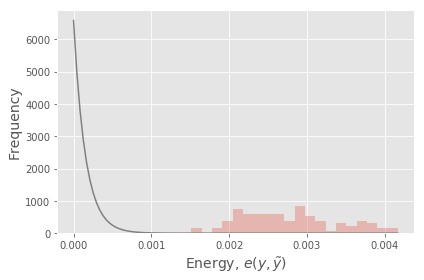

Exponential param: 0.00015200


In [6]:
# Sampling parameters.
NUM_Y_TILDES = 100
ALPHA = 10000  # 10000
save_dir = '../output'
# Define energy sensitivity for Exponential Mechanism.
energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=1)
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.8f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

(y_tildes,
 energies,
 _) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt, 'mh', NUM_Y_TILDES,
                         ALPHA, plot=1, save_dir=save_dir, power=1,
                         set_seed=True)

# PLOT RESULTS
#plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')


# Compare to Exponential density.
p = exponential_param = 2. * energy_sensitivity / ALPHA
xs = np.linspace(0, np.max(energies), 100)
xs_dens = 1 / p * np.exp(-xs / p)
plt.plot(xs, xs_dens, c='gray', label='Exponential density')
plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.savefig('../output/priv_sp_energies.png')
plt.show()
print('Exponential param: {:.8f}'.format(p))

## 4.1 Sample w/ ExpMech on Data Directly (NUM_DATA=NUM_SUPP)

In [7]:
"""
# Sampling parameters.
NUM_Y_TILDES = 21
ALPHA = 10000  # 10000
save_dir = '../output/balog_data_n_eq_m'
energy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=1)  # Note: Num supp = len(x).
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, 
                           2. * energy_sensitivity_num_data / ALPHA))

(y_tildes,
 energies,
 _) = sample_sp_exp_mech(e_opt, energy_sensitivity_num_data, x, x,  # NOTE: Instead of y_opt, use x.
                         'mh', NUM_Y_TILDES, ALPHA, plot=PLOT,
                         save_dir=save_dir,
                         power=ENERGY_POWER)

if PLOT:
    #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
    plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')


    # Compare to Exponential density.
    p = exponential_param = 2. * energy_sensitivity_num_data / ALPHA
    xs = np.linspace(0, np.max(energies), 100)
    xs_dens = 1 / p * np.exp(-xs / p)
    plt.plot(xs, xs_dens, c='gray', label='Exponential density')
    plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'priv_sp_energies.png'))
    plt.show()
    print('p: {}'.format(p))
"""

"\n# Sampling parameters.\nNUM_Y_TILDES = 21\nALPHA = 10000  # 10000\nsave_dir = '../output/balog_data_n_eq_m'\nenergy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=1)  # Note: Num supp = len(x).\nprint(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '\n   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, \n                           2. * energy_sensitivity_num_data / ALPHA))\n\n(y_tildes,\n energies,\n _) = sample_sp_exp_mech(e_opt, energy_sensitivity_num_data, x, x,  # NOTE: Instead of y_opt, use x.\n                         'mh', NUM_Y_TILDES, ALPHA, plot=PLOT,\n                         save_dir=save_dir,\n                         power=ENERGY_POWER)\n\nif PLOT:\n    #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))\n    plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')\n\n\n    # Compare to Exponential density.\n    p = exponential_param = 2. * energy_sensitivity_num_data / ALPHA\n    xs = np.linspace(0, np.max(energi

In [8]:
"""
# Compare to energies of e(y_opt, uniform)
baseline_energies = np.zeros(NUM_Y_TILDES)
for i in range(NUM_Y_TILDES):
    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
    baseline_energies[i] = e_
plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
plt.hist(baseline_energies, bins=20, alpha=0.3)
plt.show()
"""

"\n# Compare to energies of e(y_opt, uniform)\nbaseline_energies = np.zeros(NUM_Y_TILDES)\nfor i in range(NUM_Y_TILDES):\n    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))\n    baseline_energies[i] = e_\nplt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))\nplt.hist(baseline_energies, bins=20, alpha=0.3)\nplt.show()\n"

#### Paper: Figure of private support point samples with various alphas.


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 1.000) = Exp(1.52000000)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 0.66

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00037247
acceptance_rate=0.99714693, step_size=0.20033026
Energy diff: -0.01801171
acceptance_rate=0.99357602, step_size=0.20033026
Energy diff: 0.01097071
acceptance_rate=0.99333651, step_size=0.20033026
Energy diff: 0.00868551
acceptance_rate=0.99357372, step_size=0.20033026
Energy diff: 0.00020143
acceptance_rate=0.99371608, step_size=0.20033026
Energy diff: -0.00218414
acceptance_rate=0.99381100, step_size=0.20033026
Energy diff: -0.00462309
acceptance_rate=0.99408284, step_size=0.20033026
Energy diff: -0.00516680
acceptance_rate=0.99446527, step_size=0.20033026
Energy diff: -0.00093995
acceptance_rate=0.99476274, step_size=0.20033026
Energy diff: 0.03332218

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 1000.000) = Exp(0.00152

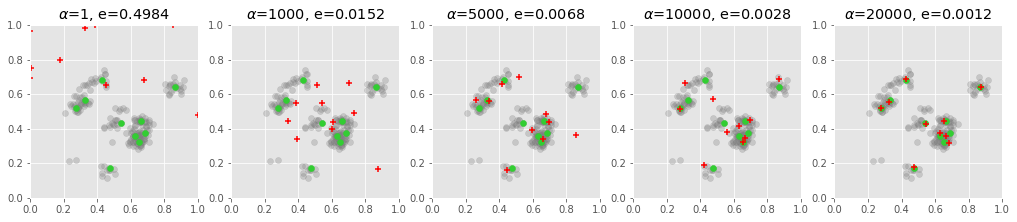

In [9]:
example_alphas = [1, 1000, 5000, 10000, 20000]
n_alp = len(example_alphas)
fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=1)


for i, alpha in enumerate(example_alphas):
    (y_tildes,
     energies,
     energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                         x, y_opt, 'mh',
                                         num_y_tildes=1,
                                         alpha=alpha,
                                         plot=False,
                                         power=ENERGY_POWER,
                                         set_seed=True)

    axs[i].set_title(r'$\alpha$={}, e={:.4f}'.format(alpha,
                                                     energies[0]))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1)
    axs[i].scatter(y_tildes[0, :, 0],
                   y_tildes[0, :, 1],
                   c='red', alpha=1,
                   marker='+')
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/sp_various_alphas.png')
plt.show()

___

## 5. Expand to full data set.

## 5.0 KDE with pre-selected bandwidth.

#### Given privately sampled SP, expand them using KDE and pre-selected bandwidth.

In [10]:
ALPHA = 1000

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=1)
energy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=1)  # Note: Num supp = len(x).

print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, 
                           2. * energy_sensitivity_num_data / ALPHA))


FULL_SAMPLE_SIZE = NUM_DATA
PLOT = 1

Exp(2 * U / alpha) = Exp(2 * 0.0399 / 1000.00) = Exp(0.00007980)



Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 1000.000) = Exp(0.00152000)

Running chain. Length=27000, Burn=25000, Thin=2000
Difference factor: 657.89

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00037247
acceptance_rate=0.30248056, step_size=0.15385364
Energy diff: 0.00151460
acceptance_rate=0.30031476, step_size=0.20033026
Energy diff: 0.00215952
acceptance_rate=0.30119738, step_size=0.20033026
Energy diff: 0.02177347
acceptance_rate=0.29932414, step_size=0.12821137
Energy diff: -0.00298302
acceptance_rate=0.30049626, step_size=0.20033026
Energy diff: 0.01422895
acceptance_rate=0.30152460, step_size=0.20033026
Energy diff: 0.00056494
acceptance_rate=0.30019576, step_size=0.20033026
Energy diff: 0.01176764
acceptance_rate=0.30026388, step_size=0.20033026
Energy diff: 0.00454331
acceptance_rate=0.30035801, step_size=0.07877306
Energy diff: 0.00079175

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 1000.000) = Exp(0.00

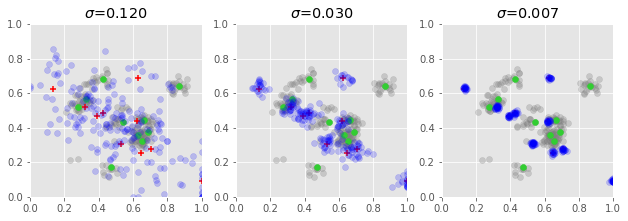

In [11]:
# Show data and y_tilde.
bandwidths = [SIGMA_DATA * 4, SIGMA_DATA, SIGMA_DATA / 4]
n_bw = len(bandwidths)

fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(bandwidths):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt,
                                                          ALPHA, bw,
                                                          FULL_SAMPLE_SIZE, 
                                                          method='mh',
                                                          power=1,
                                                          set_seed=True)

    axs[i].set_title(r'$\sigma$={:.3f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, marker='+')
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/kde_fixed_bandwidth.png')

## 5.1 KDE with DP-MLE bandwidth.

#### Compute likelihood over a range of bandwidths, and compute likelihood for each.

In [12]:
ALPHA = 1000
STEP_SIZE = 1e-2

PLOT = 1

In [13]:
ys, es, _ = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                               'mh', num_y_tildes=1, alpha=ALPHA,
                               power=1, set_seed=True)
y_tilde = ys[0]

# Sample from mixture model centered on noisy support points.
choices = np.random.choice(range(len(y_tilde)), size=NUM_DATA)
y_tilde_upsampled = y_tilde[choices]


# Find optimal bandwidth using Maximum Likelihood.
BW_LOW = 0.0001
BW_HIGH = 0.05
NUM_BANDWIDTHS = 20
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE): 
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    
    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
bw_best, bw_best_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]
bw_worst, bw_worst_lik = bw_lik[np.argmin(bw_lik, axis=0)[1]]


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 1000.000) = Exp(0.00152000)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 657.89

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00037247
acceptance_rate=0.40941512, step_size=0.20033026
Energy diff: 0.00652025
acceptance_rate=0.33047823, step_size=0.20033026
Energy diff: 0.00276477
acceptance_rate=0.29938125, step_size=0.16026421
Energy diff: 0.00316896
acceptance_rate=0.29739379, step_size=0.14769950
Energy diff: 0.00223387
acceptance_rate=0.30105684, step_size=0.20033026
Energy diff: 0.00217409
acceptance_rate=0.29969055, step_size=0.10256909
Energy diff: -0.00133029
acceptance_rate=0.30279535, step_size=0.07877306
Energy diff: 0.00093768
acceptance_rate=0.30083914, step_size=0.20033026
Energy diff: 0.00044294
acceptance_rate=0.29979368, step_size=0.12821137
Energy diff: 0.00192414
	 prod_liks=3.079e+36,
	 log_prod_liks=8.402e+01,
	 sum_lliks=8.402e+01


	 prod_liks=2.698e+

/home/maurice/privacy/mv_sp_privacy/src/sp_utils.py:915: RuntimeWarning: divide by zero encountered in log
  prod_liks, np.log(prod_liks), sum_lliks))
/home/maurice/privacy/mv_sp_privacy/src/sp_utils.py:916: RuntimeWarning: divide by zero encountered in log
  if prod_liks == 0. and np.log(prod_liks) == -np.Inf:


bw: 0.050000, llik: 8.40e+01
bw: 0.047374, llik: 8.85e+01
bw: 0.044747, llik: 9.30e+01
bw: 0.042121, llik: 9.75e+01
bw: 0.039495, llik: 1.02e+02
bw: 0.036868, llik: 1.07e+02
bw: 0.034242, llik: 1.11e+02
bw: 0.031616, llik: 1.16e+02
bw: 0.028989, llik: 1.20e+02
bw: 0.026363, llik: 1.24e+02
bw: 0.023737, llik: 1.29e+02
bw: 0.021111, llik: 1.33e+02
bw: 0.018484, llik: 1.36e+02
bw: 0.015858, llik: 1.40e+02
bw: 0.013232, llik: 1.42e+02
bw: 0.010605, llik: 1.43e+02
bw: 0.007979, llik: 1.41e+02
bw: 0.005353, llik: 1.22e+02
bw: 0.002726, llik: 1.72e+01
bw: 0.000100, llik: -1.02e+04


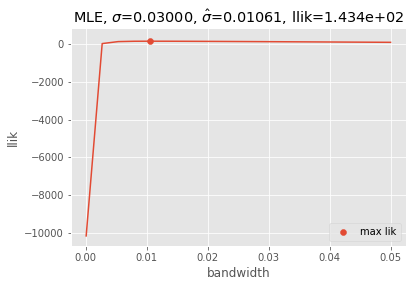

In [14]:
# Plot results for various bandwidths.
lik_str = 'llik' if do_log else 'lik'
for bw, lik in bw_lik:
    print('bw: {:.6f}, {}: {:.2e}'.format(bw, lik_str, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(bw_best, bw_best_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel(lik_str)
plt.title('MLE, $\sigma$={:.5f}, $\hat{{\sigma}}$={:.5f}, {}={:.3e}'.format(
    SIGMA_DATA, bw_best, lik_str, bw_best_lik))
plt.legend()
plt.savefig('../output/mle_bw_range.png')
plt.show()

#### Show samples with best and worst bandwidth.

	 prod_liks=2.246e+104,
	 log_prod_liks=2.403e+02,
	 sum_lliks=2.403e+02




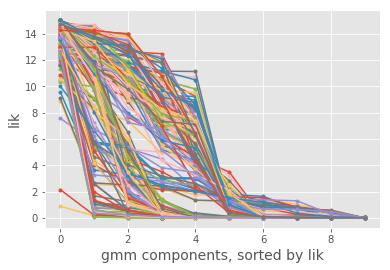

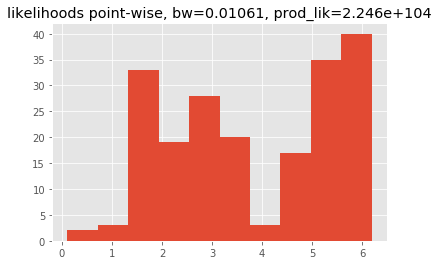

	 prod_liks=1.963e+62,
	 log_prod_liks=1.434e+02,
	 sum_lliks=1.434e+02




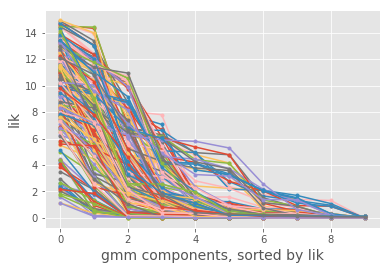

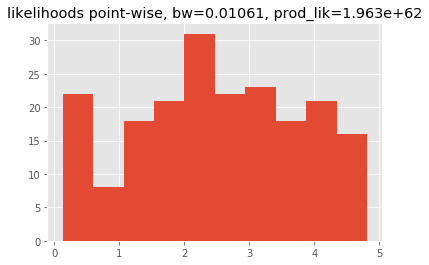

do_log: True
P(x | y_opt, bw_best): 2.40e+02
P(x | y_tilde, bw_best): 1.43e+02


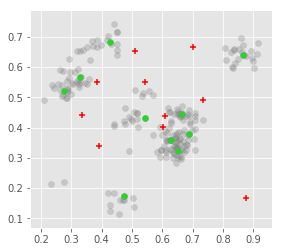

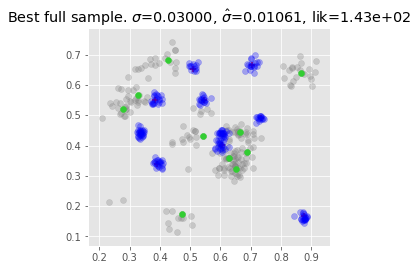

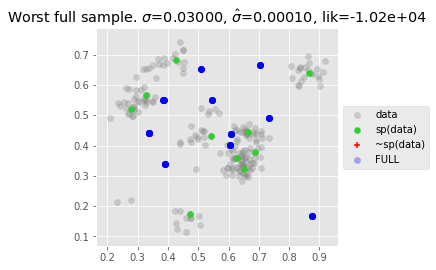

In [15]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_best,
                                        tag='Y_OPT, best bw: ',
                                        plot=True)
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_best,
                                          tag='Y_TILDE, best bw: ',
                                          plot=True)
print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_best): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_best): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample_best = (
    y_tilde_upsampled + np.random.normal(0, bw_best,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if PLOT:
    # Plot with only data and support points.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    #plt.title((r'Best full sample. $\sigma$={:.5f}, '
    #           '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
    #                                                         bw_best,
    #                                                         bw_best_lik))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('../output/mle_pre_kde.png')
    plt.show()
    
    # Plot with best bandwidth.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    plt.scatter(new_sample_best[:, 0], new_sample_best[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title((r'Best full sample. $\sigma$={:.5f}, '
               '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(
        SIGMA_DATA, bw_best, bw_best_lik))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('../output/mle_best_bw.png')
    plt.show()

    # Plot with worst bandwidth.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title((r'Worst full sample. $\sigma$={:.5f}, '
                '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
                                                              bw_worst,
                                                              bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### Sample full synthetic set with DP sample of MLE bandwidth.

In this setting, for positive bandwidth $\sigma$, Gaussian data up to $4\sigma$ is bounded on $[0, 1]$ by restricting cluster centers to $[0 + 4\sigma, 1 - 4\sigma]$. The largest $\sigma$ that accommodates this bound is $\sigma = 1/8$. With sensitivity $\Delta f = 1/8$, we sample a DP bandwidth $\tilde{\sigma} \sim \mbox{Lap}(\sigma, \frac{1/8}{\alpha})$, and enforce a non-trivially small positive floor value $\delta$, with $\max(\tilde{\sigma}, \delta)$.


Best bw:       0.010605
raw DP bw:     0.010482
Corrected DP bw: 0.010482

Best bw:       0.010605
raw DP bw:     0.010539
Corrected DP bw: 0.010539

Best bw:       0.010605
raw DP bw:     0.010678
Corrected DP bw: 0.010678

Best bw:       0.010605
raw DP bw:     0.010330
Corrected DP bw: 0.010330


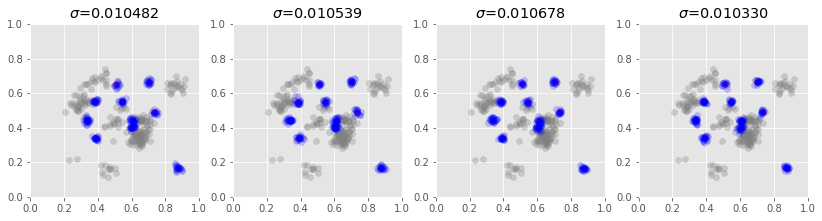

In [16]:
dp_bandwidths = []
floor = 1e-3
n_bw = 4

for _ in range(n_bw):
    dp_bandwidth_raw = bw_best + np.random.laplace(loc=0, scale=(1 / 8) / ALPHA)
    dp_bandwidth = np.max([dp_bandwidth_raw, floor])
    dp_bandwidths.append(dp_bandwidth)
    print('\nBest bw: {:>14.6f}\nraw DP bw: {:>12.6f}\nCorrected DP bw: {:>1.6f}'.format(
            bw_best, dp_bandwidth_raw, dp_bandwidth))



fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(dp_bandwidths):
    y_tilde_expansion = (
        y_tilde_upsampled +
        np.random.normal(0, bw, size=(FULL_SAMPLE_SIZE, x.shape[1])))


    axs[i].set_title(r'$\sigma$={:.6f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/mle_bw_dp.png')

## 5.3 Repeated draws of private support points.

#### Once with lower budget to show disperse output.


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 1000.000) = Exp(0.00152000)

Running chain. Length=27000, Burn=25000, Thin=2000
Difference factor: 657.89

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00020456
acceptance_rate=0.30507220, step_size=0.20033026
Energy diff: 0.01038133
acceptance_rate=0.29957415, step_size=0.20033026
Energy diff: 0.01185752
acceptance_rate=0.30008641, step_size=0.20033026
Energy diff: 0.00499343
acceptance_rate=0.30024998, step_size=0.10256909
Energy diff: 0.00550430
acceptance_rate=0.30182949, step_size=0.20033026
Energy diff: 0.01039524
acceptance_rate=0.30121597, step_size=0.20033026
Energy diff: 0.01500412
acceptance_rate=0.29993122, step_size=0.12821137
Energy diff: 0.00054559
acceptance_rate=0.29980094, step_size=0.12821137
Energy diff: 0.01604951
acceptance_rate=0.29990535, step_size=0.12821137
Energy diff: 0.00020590

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 1000.000) = Exp(0.001

acceptance_rate=0.30433173, step_size=0.18462437
Energy diff: 0.01644595
acceptance_rate=0.30142566, step_size=0.12308291
Energy diff: 0.00395401
acceptance_rate=0.30119738, step_size=0.20033026
Energy diff: 0.01385632
acceptance_rate=0.30210166, step_size=0.20033026
Energy diff: -0.00128247
acceptance_rate=0.30049626, step_size=0.20033026
Energy diff: 0.01137317
acceptance_rate=0.30115425, step_size=0.20033026
Energy diff: 0.00034657
acceptance_rate=0.30104227, step_size=0.11815960
Energy diff: 0.00252016
acceptance_rate=0.30021758, step_size=0.20033026
Energy diff: 0.00540998
acceptance_rate=0.30113987, step_size=0.20033026
Energy diff: 0.01571492

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 1000.000) = Exp(0.00152000)

Running chain. Length=27000, Burn=25000, Thin=2000
Difference factor: 657.89

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00022122
acceptance_rate=0.30285080, step_size=0.20033026
Energy diff: 0.02311605
acceptance_rate=0.

acceptance_rate=0.30142566, step_size=0.12308291
Energy diff: 0.00079357
acceptance_rate=0.29946920, step_size=0.20033026
Energy diff: 0.01434581
acceptance_rate=0.30163874, step_size=0.20033026
Energy diff: 0.01655871
acceptance_rate=0.30064440, step_size=0.20033026
Energy diff: 0.01799012
acceptance_rate=0.29954941, step_size=0.16026421
Energy diff: 0.01233947
acceptance_rate=0.30014285, step_size=0.20033026
Energy diff: 0.00232714
acceptance_rate=0.30128235, step_size=0.20033026
Energy diff: 0.00367116
acceptance_rate=0.30056376, step_size=0.20033026
Energy diff: 0.00192339

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 1000.000) = Exp(0.00152000)

Running chain. Length=27000, Burn=25000, Thin=2000
Difference factor: 657.89

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00031892
acceptance_rate=0.30544243, step_size=0.20033026
Energy diff: 0.00235080
acceptance_rate=0.30327717, step_size=0.20033026
Energy diff: -0.00400691
acceptance_rate=0.

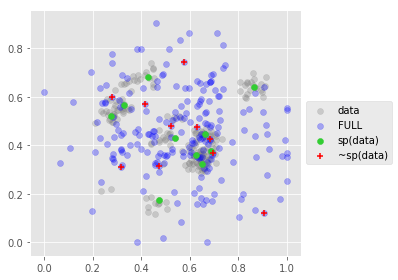

In [17]:
ALPHA = 1000

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(NUM_DATA / NUM_SUPP) + 1
FULL_SAMPLE_SIZE = NUM_DATA

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=1)


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt, ALPHA,
                                                          BANDWIDTH,
                                                          FULL_SAMPLE_SIZE,
                                                          method='mh',
                                                          power=1,
                                                          set_seed=False)
    new_sample.append(y_tilde)

new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('MH, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3, label='FULL')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1, label='sp(data)')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, label='~sp(data)', marker='+')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/repeated_samples_dispersed.png')
plt.show()

#### Once with higher budget to show focused output.


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 20000.000) = Exp(0.00007600)

Running chain. Length=27000, Burn=25000, Thin=2000
Difference factor: 13157.89

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00035848
acceptance_rate=0.27508330, step_size=0.06564422
Energy diff: 0.00390578
acceptance_rate=0.28624329, step_size=0.06564422
Energy diff: 0.00297292
acceptance_rate=0.30058018, step_size=0.20033026
Energy diff: 0.00075397
acceptance_rate=0.30700861, step_size=0.14971054
Energy diff: 0.00749764
acceptance_rate=0.30642175, step_size=0.09024796
Energy diff: 0.00223148
acceptance_rate=0.30893155, step_size=0.05013776
Energy diff: 0.00179310
acceptance_rate=0.31299931, step_size=0.02417909
Energy diff: 0.00004018
acceptance_rate=0.31165224, step_size=0.00562328
Energy diff: 0.00013806
acceptance_rate=0.30525493, step_size=0.00156936
Energy diff: -0.00000051

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 20000.000) = Exp(


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 20000.000) = Exp(0.00007600)

Running chain. Length=27000, Burn=25000, Thin=2000
Difference factor: 13157.89

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00024874
acceptance_rate=0.26101444, step_size=0.00600661
Energy diff: -0.00006793
acceptance_rate=0.28346602, step_size=0.00199505
Energy diff: -0.00000124
acceptance_rate=0.29144550, step_size=0.00147818
Energy diff: -0.00004422
acceptance_rate=0.28951023, step_size=0.00288706
Energy diff: 0.00011164
acceptance_rate=0.29094141, step_size=0.00360883
Energy diff: -0.00003210
acceptance_rate=0.29158694, step_size=0.00360883
Energy diff: 0.00002250
acceptance_rate=0.29183641, step_size=0.00563880
Energy diff: 0.00012020
acceptance_rate=0.29313458, step_size=0.01376659
Energy diff: 0.00061678
acceptance_rate=0.29365047, step_size=0.01720824
Energy diff: 0.00037100

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 20000.000) = E


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 20000.000) = Exp(0.00007600)

Running chain. Length=27000, Burn=25000, Thin=2000
Difference factor: 13157.89

acceptance_rate=0.00000000, step_size=0.01000000
Energy diff: 0.00073048
acceptance_rate=0.28878193, step_size=0.10690479
Energy diff: 0.00387900
acceptance_rate=0.29401963, step_size=0.12821137
Energy diff: 0.00091335
acceptance_rate=0.29811134, step_size=0.16026421
Energy diff: 0.00229218
acceptance_rate=0.30136099, step_size=0.20033026
Energy diff: 0.00191318
acceptance_rate=0.30227391, step_size=0.18713817
Energy diff: 0.00316076
acceptance_rate=0.30263564, step_size=0.15594848
Energy diff: 0.00769563
acceptance_rate=0.30739114, step_size=0.08663804
Energy diff: 0.00410424
acceptance_rate=0.31007824, step_size=0.02417909
Energy diff: 0.00058926
acceptance_rate=0.30797087, step_size=0.01457555
Energy diff: 0.00017451

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.7600 / 20000.000) = Exp(0

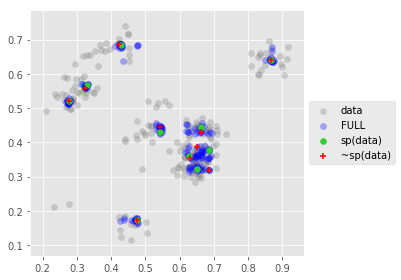

In [18]:
ALPHA = 20000

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(NUM_DATA / NUM_SUPP) + 1
FULL_SAMPLE_SIZE = NUM_DATA

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=1)


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt, ALPHA,
                                                          BANDWIDTH,
                                                          FULL_SAMPLE_SIZE,
                                                          method='mh',
                                                          power=1,
                                                          set_seed=False)
    new_sample.append(y_tilde)

new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('MH, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3, label='FULL')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1, label='sp(data)')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, label='~sp(data)', marker='+')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/repeated_samples_focused.png')
plt.show()

# End.